# Notebook For Q&A Retrival Evaluation 

In [1]:
import sys
sys.path.append('../models/src')

# Now you can import hypno
from hypnoq_chain import embed_model
from eval_functions import cosin_similarity

/home/codespace/.cache/pypoetry/virtualenvs/models-io_XXpQJ-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 5 files: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41445.69it/s]


In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ast

from tqdm import tqdm
from numpy import dot
from numpy.linalg import norm

from langchain_community.embeddings.fastembed import FastEmbedEmbeddings

### Load the llm results file for evaluation

In [3]:
df_llm = pd.read_csv('llm_results.csv')
llm_results = df_llm.to_dict(orient='records')
llm_results[2]

{'doc_id': '20429cbf-fb68-4938-9833-e96fc3195fa3',
 'question': 'My approach',
 'orig_answer': 'Your treatment plan will be tailored to your specific individual needs and goals and will be conducted in a safe, comfortable environment where you feel you can explore anything without fear of judgment or embarrassment. I am fun, practical and down to earth – and that’s exactly how you can expect sessions with me to be.',
 'llm_answer': "Thank you for considering hypnotherapy services. Based on the provided context, the hypnotherapist's approach is tailored to each individual's specific needs and goals. This personalized treatment plan is conducted in a safe and comfortable environment where you can feel free to explore anything without fear of judgment or embarrassment. The hypnotherapist is described as fun, practical, and down-to-earth, ensuring that sessions will be enjoyable and approachable.\n\nPlease note that if you have any specific questions or concerns about the hypnotherapy serv

## Cosin similarity Evaluation  
cosine similarity is a measure of similarity between two non-zero vectors defined in an inner product space.  
Cosine similarity is the cosine of the angle between the vectors; that is, it is the dot product of the vectors divided by the product of their lengths.

In [5]:
similarity = []

for record in tqdm(llm_results):
    a = embed_model.embed_query(record['orig_answer'])
    b = embed_model.embed_query(record['llm_answer'])
    sim = cosin_similarity(a,b)
    similarity.append(sim)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:16<00:00,  1.00it/s]


In [6]:
df_llm['cosine'] = similarity
df_llm['cosine'].describe()

count    17.000000
mean      0.842535
std       0.060194
min       0.721417
25%       0.814813
50%       0.830670
75%       0.899924
max       0.943968
Name: cosine, dtype: float64

## Cosin Similarity Plot  

Overall the similarity is about 0.72, and most of the answers are abouve 0.80 

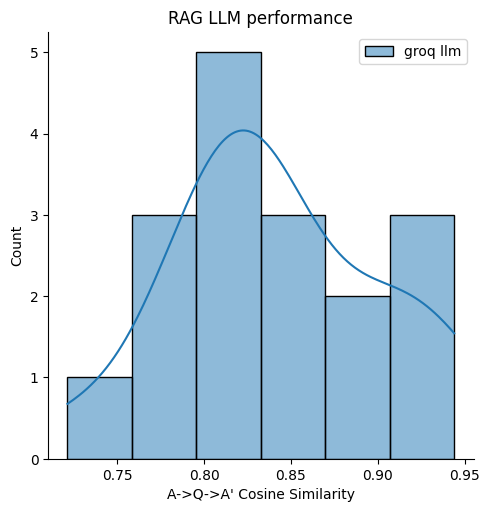

In [16]:
# Using histplot to plot a histogram
sns.displot(df_llm['cosine'], kde=True, label='groq llm')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-Judge

In [18]:
# Now you can import hypno
from hypnoq_chain import vector_store, groq_llm
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import (
    PromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
)


In [25]:
llm_judge_prompt = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {orig_answer}
Generated Question: {question}
Generated Answer: {llm_answer}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
"""

In [26]:

judge_system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(input_variables=["orig_answer", "question","llm_answer"], template=llm_judge_prompt)
)

messages = [judge_system_prompt]

judge_tamplate = ChatPromptTemplate(
    input_variables=["orig_answer", "question","llm_answer"], messages=messages
)

output_parser = StrOutputParser()

judge_chain = judge_tamplate | groq_llm | output_parser


In [27]:
test = llm_results[2]

In [32]:
reply = judge_chain.invoke(test)
print(reply)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer accurately summarizes and rephrases the original answer, covering all the key points including the personalized treatment plan, safe and comfortable environment, and the hypnotherapist's approachable and down-to-earth personality."
}


In [43]:
evaluations = dict(Doc_id=[], Relevance=[], Explanation=[])

for record in tqdm(llm_results):
    evaluation = judge_chain.invoke(record)
    
    try:
        actual_eval = ast.literal_eval(evaluation)
        # Try to convert the string to an actual list
        relevance = actual_eval.get("Relevance", None)
        explenation = actual_eval.get("Explanation", None)
    except (SyntaxError, ValueError) as e:
        print(f"Error parsing the string: {e}")
        continue
    
    evaluations['Doc_id'].append(record['doc_id'])
    evaluations['Relevance'].append(relevance)
    evaluations['Explanation'].append(explenation)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [01:15<00:00,  4.46s/it]


In [46]:
df_eval = pd.DataFrame.from_dict(evaluations)
df_eval.head(5)

,Doc_id,Relevance,Explanation
0,34cdb806-9fd2-4b74-895a-134bfdb7bcac,PARTLY_RELEVANT,The generated answer is partly relevant as it ...
1,56e6efa8-ef1c-4c09-aafd-80e3e0764346,RELEVANT,The generated answer accurately summarizes the...
2,20429cbf-fb68-4938-9833-e96fc3195fa3,RELEVANT,The generated answer accurately summarizes and...
3,55e90ead-8d05-496f-86a5-d0ec121cbe5d,RELEVANT,The generated answer accurately captures the m...
4,1ef71159-8d1d-4f78-85c4-31bfefcb23f6,PARTLY_RELEVANT,The generated answer is partially relevant as ...


In [47]:
df_eval.Relevance.value_counts()

Relevance
RELEVANT           12
PARTLY_RELEVANT     5
Name: count, dtype: int64

## RAG Relevance Metrics :  
---------------------------  
RELEVANT           12 (/ 17) ~ 70%  
PARTLY_RELEVANT     5 (/ 17) ~ 30%  